IEEE-CIS Fraud Detection - LightAutoML (LAMA) Baseline

Этот ноутбук содержит базовое решение с использованием LightAutoML.

Содержание:
1. Загрузка данных
2. Предобработка данных
3. Стратегия валидации
4. LAMA Baseline - Конфигурация 1
5. LAMA Baseline - Конфигурация 2
6. Сравнение результатов
7. Создание submission

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2,4,5,6,7"

In [2]:
import sys
import warnings
import gc
import time
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

In [3]:
from pathlib import Path
from dataclasses import dataclass
from typing import List
from utils import load_data

DATA_DIR = Path("data")
SUBMISSIONS_DIR = Path("submissions")

In [4]:
@dataclass
class FeatureConfig:
    """Конфигурация признаков датасета"""
    cat_transaction = None
    cat_identity = None
    target = "isFraud"
    id_col = "TransactionID"
    time_col = "TransactionDT"

FEATURE_CONFIG = FeatureConfig()

train, test, sample_sub = load_data(DATA_DIR)

Train shape: (590540, 434), Test shape: (506691, 433)


In [5]:
# Замена колонок в test для согласованности в train
test_columns = test.columns
test_columns = [col.replace("-", "_") for col in test_columns]
test = pd.DataFrame(test, columns=test_columns)

In [6]:
len(set(train.columns).intersection(set(test.columns)))

433

In [7]:
target = FEATURE_CONFIG.target
id_col = FEATURE_CONFIG.id_col

# Список признаков - исключаем отсюда ID и target
feature_cols = [col for col in train.columns if col not in [id_col, target]]

print(f"Целевая переменная: {target}")
print(f"Количество признаков: {len(feature_cols)}")
print(f"Fraud rate: {train[target].mean()*100:.2f}%")

Целевая переменная: isFraud
Количество признаков: 432
Fraud rate: 3.50%


In [8]:
def clean_data(
    df, df_test, target_col, id_col
):
    """
    Минимальная очистка данных перед LAMA
    """
    df = df.copy()

    exclude_cols = [target_col, id_col]
    feature_cols = [col for col in df.columns if col not in exclude_cols]
    
    # Удалим колонок с > 95% пропусков
    missing_pct = df[feature_cols].isnull().mean()
    high_missing_cols = missing_pct[missing_pct > 0.95].index.tolist()
    print(f"Колонок с > 95% пропусков: {len(high_missing_cols)}")
    
    df = df.drop(columns=high_missing_cols, errors='ignore')
    df_test = df_test.drop(columns=high_missing_cols, errors='ignore')
    
    print(f"Итоговый shape train: {df.shape}")
    print(f"Итоговый shape test: {df_test.shape}")
    
    return df, df_test, high_missing_cols

train_clean, test_clean, removed_cols = clean_data(
    train, test, target_col=target, id_col=id_col
)

Колонок с > 95% пропусков: 9
Итоговый shape train: (590540, 425)
Итоговый shape test: (506691, 424)


In [9]:
def add_basic_features(df):
    """
    Добавление базовых фичей
    """
    df = df.copy()
    
    # Признаки из временных фичей
    df['hour'] = (df['TransactionDT'] // 3600) % 24
    df['day'] = df['TransactionDT'] // 86400
    df['weekday'] = df['day'] % 7
    df['is_weekend'] = (df['weekday'] >= 5).astype(np.int8)
    df['is_night'] = ((df['hour'] >= 0) & (df['hour'] <= 6)).astype(np.int8)

    # Количество пропусков в строке
    df['n_missing'] = df.isnull().sum(axis=1)
    
    # Доля пропусков
    df['missing_ratio'] = df['n_missing'] / df.shape[1]
   
    # Количество пропусков в identity колонках
    id_cols = [col for col in df.columns if col.startswith('id_')]
    df['n_missing_identity'] = df[id_cols].isnull().sum(axis=1)
    
    # Количество пропусков в V колонках
    v_cols = [col for col in df.columns if col.startswith('V')]
    df['n_missing_V'] = df[v_cols].isnull().sum(axis=1)
    
    # Логарифм суммы транзакции
    df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'])
    # Флаг круглой суммы
    df['is_round_amount'] = (df['TransactionAmt'] % 1 == 0).astype(np.int8)

    return df

train_fe = add_basic_features(train_clean)
test_fe = add_basic_features(test_clean)

new_features = [col for col in train_fe.columns if col not in train_clean.columns]
print(f"Добавлено новых признаков: {len(new_features)}")
print(f"Список: {new_features}")

print(f"Train с FE shape: {train_fe.shape}")
print(f"Test с FE shape: {test_fe.shape}")

Добавлено новых признаков: 11
Список: ['hour', 'day', 'weekday', 'is_weekend', 'is_night', 'n_missing', 'missing_ratio', 'n_missing_identity', 'n_missing_V', 'TransactionAmt_log', 'is_round_amount']
Train с FE shape: (590540, 436)
Test с FE shape: (506691, 435)


### Выбор стратегии сплита валидации

- Данные содержат временную компоненту (TransactionDT)
- Транзакции отсортированы по времени
- В реальности мы предсказываем будущие транзакции

Варианты:
1. Random Stratified Split
2. Time-based Split
3. GroupKFold by day

Выбор: Time-based Split

Обоснование:
- Предотвращает утечку данных из будущего
- Соответствует реальному сценарию использования модели
- Test set соревнования также отсортирован по времени

Реализация:
- Train: первые 80% данных по времени
- Validation: последние 20% данных по времени

In [10]:
def time_based_split(df, time_col, train_size):
    """
    Time-based split
    """
    df_sorted = df.sort_values(time_col).reset_index(drop=True)
    split_idx = int(len(df_sorted) * train_size)
    
    train_idx = df_sorted.index[:split_idx]
    val_idx = df_sorted.index[split_idx:]
    
    return train_idx, val_idx

train_idx, val_idx = time_based_split(train_clean, 'TransactionDT', train_size=0.8)

print(f"Train size: {len(train_idx):}")
print(f"Validation size: {len(val_idx):}")

train_sorted = train_clean.sort_values('TransactionDT')
print(f"Train period: day 0 - day {train_sorted.iloc[train_idx[-1]]['TransactionDT'] // 86400:.0f}")
print(f"Val period: day {train_sorted.iloc[val_idx[0]]['TransactionDT'] // 86400:.0f} - "
      f"day {train_sorted.iloc[val_idx[-1]]['TransactionDT'] // 86400:.0f}")

print(f"Train fraud rate: {train_clean.iloc[train_idx][target].mean()*100:.2f}%")
print(f"Val fraud rate: {train_clean.iloc[val_idx][target].mean()*100:.2f}%")

Train size: 472432
Validation size: 118108
Train period: day 0 - day 141
Val period: day 141 - day 182
Train fraud rate: 3.51%
Val fraud rate: 3.44%


## LAMA Baseline - первая конфигурация

Параметры конфигурации 1:
- timeout: 1200 секунд
- cpu_limit: 4 ядра
- CV 3-fold

In [11]:
train_data_config1 = train_clean.sort_values('TransactionDT').reset_index(drop=True)
train_part_config1 = train_data_config1.iloc[:len(train_idx)].copy()
val_part_config1 = train_data_config1.iloc[len(train_idx):].copy()

feature_cols_config1 = [col for col in train_part_config1.columns if col not in [id_col, target]]

print(f"Количество признаков: {len(feature_cols_config1)}")

Количество признаков: 423


In [12]:
task = Task('binary', metric='auc')

# Конфигурация 1 - подготоим данные и обучение запустим
automl_config1 = TabularAutoML(
    task=task,
    timeout=1200,
    cpu_limit=4,
    reader_params={
        'n_jobs': 4,
        'cv': 3,  # 3-fold CV для скорости
        'random_state': 42
    }
)

start_time = time.time()

train_lama = train_part_config1[feature_cols_config1 + [target]].copy()

pred_config1 = automl_config1.fit_predict(
    train_lama,
    roles={'target': target},
    verbose=1
)

train_time_config1 = time.time() - start_time
val_pred_config1 = automl_config1.predict(val_part_config1[feature_cols_config1])
val_auc_config1 = roc_auc_score(val_part_config1[target], val_pred_config1.data[:, 0])
print(f"Время обучения: {train_time_config1 / 60:.1f} минут")
print(f"Validation ROC-AUC (config 1): {val_auc_config1:.5f}")

[18:57:44] Stdout logging level is INFO.
[18:57:44] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[18:57:44] Task: binary

[18:57:44] Start automl preset with listed constraints:
[18:57:44] - time: 1200.00 seconds
[18:57:44] - CPU: 4 cores
[18:57:44] - memory: 16 GB

[18:57:44] Train data shape: (472432, 424)

[18:58:11] Layer 1 train process start. Time left 1172.94 secs
[18:58:39] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:00:04] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.9092707023928949
[19:00:04] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[19:00:04] Time left 1060.26 secs

[19:02:28] Selector_LightGBM fitting and predicting completed
[19:02:53] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[19:04:53] Time limit exceeded after calculating fold 0

[19:04:53] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.9585722886675472
[19:04:53] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting co

Optimization Progress:   8%| | 8/101 [02:29<28:54, 18.65s/it, best_trial=6, best

[19:08:38] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost completed
[19:08:38] Start fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost ...


[19:10:21] Fitting Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost finished. score = 0.9444461271751803
[19:10:21] Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost fitting and predicting completed
[19:10:21] Time left 443.07 secs

[19:10:21] Time limit exceeded in one of the tasks. AutoML will blend level 1 models.

[19:10:21] Layer 1 training completed.

[19:10:21] Blending: optimization starts with equal weights. Score = 0.9427761
[19:10:24] Blending: iteration 0: score = 0.9496434, weights = [0.         0.77357525 0.11321239 0.11321239]
[19:10:26] Blending: no improvements for score. Terminated.

[19:10:26] Blending: best score = 0.9496434, best weights = [0.         0.77357525 0.11321239 0.11321239]
[19:10:26] Automl preset training completed in 762.19 seconds

[19:10:26] Model description:
Final prediction for new objects (level 0) = 
	 0.77358 * (1 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.11321 * (3 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.11321 * (3 averaged models Lvl_0_Pipe_1_Mod_3_Tun

## LAMA Baseline - второй конфиг

Параметры конфигурации 1:
- timeout: 1800 секунд
- cpu_limit: 4 ядра
- CV 5-fold
- фичи после инжиниринга

In [13]:
train_data_config2 = train_fe.sort_values('TransactionDT').reset_index(drop=True)
train_part_config2 = train_data_config2.iloc[:len(train_idx)].copy()
val_part_config2 = train_data_config2.iloc[len(train_idx):].copy()

feature_cols_config2 = [col for col in train_part_config2.columns if col not in [id_col, target]]
print(f"Количество признаков: {len(feature_cols_config2)}")

Количество признаков: 434


In [14]:
# Конфигурация 2: Расширенный baseline
automl_config2 = TabularUtilizedAutoML(
    task=task,
    timeout=1800,
    cpu_limit=4,
    reader_params={
        'n_jobs': 4,
        'cv': 5,  # 5-fold CV
        'random_state': 42
    }
)

In [17]:
start_time = time.time()

train_lama_config2 = train_part_config2[feature_cols_config2 + [target]].copy()

pred_config2 = automl_config2.fit_predict(
    train_lama_config2,
    roles={'target': target},
    verbose=1
)

train_time_config2 = time.time() - start_time

val_pred_config2 = automl_config2.predict(val_part_config2[feature_cols_config2])
val_auc_config2 = roc_auc_score(val_part_config2[target], val_pred_config2.data[:, 0])

print(f"Время обучения: {train_time_config2 / 60:.1f} минут")
print(f"Validation ROC-AUC (config 2): {val_auc_config2:.5f}")

[19:46:22] Start automl utilizator with listed constraints:
[19:46:22] - time: 1800.00 seconds
[19:46:22] - CPU: 4 cores
[19:46:22] - memory: 16 GB

[19:46:22] If one preset completes earlier, next preset configuration will be started

[19:46:22] ==================================================
[19:46:22] Start 0 automl preset configuration:
[19:46:22] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'nn_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[19:46:22] Stdout logging level is INFO.
[19:46:22] Task: binary

[19:46:22] Start automl preset with listed constraints:
[19:46:22] - time: 1800.00 seconds
[19:46:22] - CPU: 4 cores
[19:46:22] - memory: 16 GB

[19:46:22] Train data shape: (472432, 435)

[19:46:52] Layer 1 train process start. Time left 1769.99 secs
[19:47:20] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[19:48:55] Time limit exceeded after calculating fold 2

[19:48:55] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2

## Анализ результатов

In [19]:
# Выберем лучшей конфигурации
if val_auc_config2 >= val_auc_config1:
    best_automl = automl_config2
    best_val_pred = val_pred_config2
    best_auc = val_auc_config2
    best_config = "Config 2"
    best_feature_cols = feature_cols_config2
    best_test_data = test_fe
else:
    best_automl = automl_config1
    best_val_pred = val_pred_config1
    best_auc = val_auc_config1
    best_config = "Config 1"
    best_feature_cols = feature_cols_config1
    best_test_data = test_clean

print(f"Лучшая конфигурация: {best_config}")
print(f"Лучший Validation AUC: {best_auc:.5f}")

Лучшая конфигурация: Config 1
Лучший Validation AUC: 0.90384


In [20]:
# Делаем предикт на тестовых данных лучшей моделью

test_pred = best_automl.predict(best_test_data[best_feature_cols])

submission = sample_sub.copy()
submission['isFraud'] = test_pred.data[:, 0]

print(f"Предсказания:")
print(f"  min: {submission['isFraud'].min():.6f}")
print(f"  max: {submission['isFraud'].max():.6f}")

submission_path = SUBMISSIONS_DIR / f'lama_baseline.csv'
submission.to_csv(submission_path, index=False)

Предсказания:
  min: 0.000025
  max: 0.999678


Итого, что было сделано:

Предобработка данных:
1. Удалены колонки с >95% пропусков
2. Базовый Feature Engineering (в конфиге 2):
- Временные: hour, day, weekday, is_weekend, is_night
- Пропуски: n_missing, missing_ratio, n_missing_identity, n_missing_V
- TransactionAmt: TransactionAmt_log, is_round_amount

Валидация:
- Time-based split 80/20 для предотвращения data leakage

Следующие шаги: я буду пытаться превзойти лучший baseline с помощью:
1. Продвинутого feature engineering
2. LightGBM/CatBoost с оптимизацией гиперпараметров
3. Ансамблирования моделей

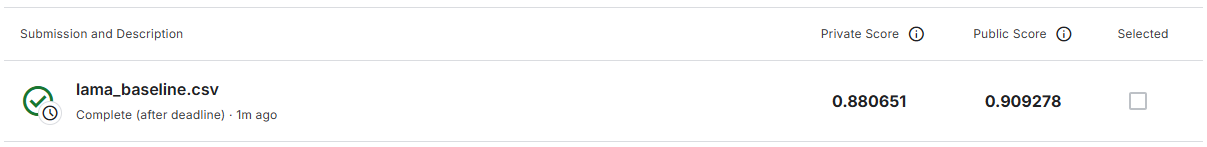